In [213]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd


In [214]:
df = pd.read_csv("../data/train_imputed_weather_merged.csv")

In [215]:
df.rename(columns={"Unnamed: 0": "date"}, inplace=True)

In [216]:
df

,date,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,apparent_temperature,cloud_cover,cloud_cover_high,cloud_cover_low,...,precipitation_hours,precipitation_sum,rain_sum,shortwave_radiation_sum,snowfall_sum,sunshine_duration,temperature_2m_max,temperature_2m_min,wind_gusts_10m_max,wind_speed_10m_max
0,2020-01-01 00:00:00,42.900000,0.718000,15.7,73.1,64.4,0.337214,87.299995,0.0,97.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
1,2020-01-01 01:00:00,33.600000,0.587000,10.1,74.8,66.0,-0.233696,85.500000,0.0,95.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
2,2020-01-01 02:00:00,29.300000,0.447374,5.1,51.0,44.9,-0.615977,84.599998,0.0,94.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
3,2020-01-01 03:00:00,30.500000,0.246000,7.2,27.7,25.1,-0.663568,84.599998,0.0,94.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
4,2020-01-01 04:00:00,29.300000,0.204000,8.3,15.3,13.6,-0.911623,89.099998,0.0,99.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,24.737806,0.222000,55.1,12.0,5.3,19.869907,38.700001,100.0,3.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40987,2024-09-03 19:00:00,26.877610,0.245000,48.2,13.4,7.0,18.508705,33.300003,100.0,1.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40988,2024-09-03 20:00:00,24.648191,0.234000,44.5,12.4,7.1,16.772964,42.300003,100.0,13.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40989,2024-09-03 21:00:00,23.953074,0.225000,25.9,10.6,5.4,15.663885,40.200001,100.0,8.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530


In [217]:
df.set_index("date", inplace=True)

df.index = pd.to_datetime(df.index)

In [218]:
# Specify target columns
target_columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]
feature_columns = [col for col in df.columns if col not in target_columns]

In [177]:
# Scale features and targets separately to avoid data leakage
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()


In [178]:
df[feature_columns] = scaler_features.fit_transform(df[feature_columns])
df[target_columns] = scaler_targets.fit_transform(df[target_columns])


In [179]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, feature_columns, target_columns=None, seq_length=24):
        self.features = df[feature_columns].values
        self.targets = df[target_columns].values if target_columns is not None else None
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, index):
        x = self.features[index : index + self.seq_length, :]
        if self.targets is not None:
            y = self.targets[index + self.seq_length, :]
            return torch.tensor(x, dtype=torch.float32), torch.tensor(
                y, dtype=torch.float32
            )
        else:
            return torch.tensor(x, dtype=torch.float32)  # No target if predicting


In [180]:
# Parameters
SEQ_LENGTH = 24  # Use last 24 hours as input
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001


In [181]:
# Create train and test datasets
train_size = int(0.8 * len(df))
train_dataset = TimeSeriesDataset(
    df.iloc[:train_size], feature_columns, target_columns, seq_length=SEQ_LENGTH
)
test_dataset = TimeSeriesDataset(
    df.iloc[train_size:], feature_columns, target_columns, seq_length=SEQ_LENGTH
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [182]:
# Define the LSTM-based model
class MultiTargetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, target_size, num_layers=2):
        super(MultiTargetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, target_size)

    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 64).to(x.device)  # Initialize hidden state
        c_0 = torch.zeros(2, x.size(0), 64).to(x.device)  # Initialize cell state

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(lstm_out[:, -1, :])  # Only use the last output of LSTM
        return out


In [183]:
# Initialize the model, loss function, and optimizer
input_size = len(feature_columns)
hidden_size = 64
target_size = len(target_columns)


In [184]:
model = MultiTargetLSTM(
    input_size=input_size, hidden_size=hidden_size, target_size=target_size
).to("cuda")
criterion = criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# def weighted_mae_loss(outputs, targets):
#     mae = criterion(outputs, targets)
#     weighted_mae = mae * weights  # Apply weights to each target's error
#     return weighted_mae.mean()

In [185]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}")


Epoch [1/50], Train Loss: 0.0319
Epoch [2/50], Train Loss: 0.0265
Epoch [3/50], Train Loss: 0.0251
Epoch [4/50], Train Loss: 0.0242
Epoch [5/50], Train Loss: 0.0238
Epoch [6/50], Train Loss: 0.0232
Epoch [7/50], Train Loss: 0.0227
Epoch [8/50], Train Loss: 0.0222
Epoch [9/50], Train Loss: 0.0217
Epoch [10/50], Train Loss: 0.0216
Epoch [11/50], Train Loss: 0.0210
Epoch [12/50], Train Loss: 0.0207
Epoch [13/50], Train Loss: 0.0204
Epoch [14/50], Train Loss: 0.0199
Epoch [15/50], Train Loss: 0.0197
Epoch [16/50], Train Loss: 0.0194
Epoch [17/50], Train Loss: 0.0190
Epoch [18/50], Train Loss: 0.0187
Epoch [19/50], Train Loss: 0.0183
Epoch [20/50], Train Loss: 0.0181
Epoch [21/50], Train Loss: 0.0177
Epoch [22/50], Train Loss: 0.0174
Epoch [23/50], Train Loss: 0.0172
Epoch [24/50], Train Loss: 0.0169
Epoch [25/50], Train Loss: 0.0167
Epoch [26/50], Train Loss: 0.0164
Epoch [27/50], Train Loss: 0.0160
Epoch [28/50], Train Loss: 0.0158
Epoch [29/50], Train Loss: 0.0156
Epoch [30/50], Train Lo

In [186]:
# Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * x_batch.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0284


In [187]:
# Example of making predictions (e.g., on test data)
with torch.no_grad():
    predictions = []
    actuals = []
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to("cuda")
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

# Reverse the scaling for better interpretability if needed
predictions = scaler_targets.inverse_transform(predictions)
actuals = scaler_targets.inverse_transform(actuals)


In [188]:
# Calculate mean absolute error
mae = np.mean(np.abs(predictions - actuals), axis=0)
print("Mean Absolute Error (MAE):")
print(pd.Series(mae, name="MAE", index=target_columns))


Mean Absolute Error (MAE):
valeur_NO2      7.512982
valeur_CO       0.050319
valeur_O3      11.769506
valeur_PM10     6.508308
valeur_PM25     4.240723
Name: MAE, dtype: float32


In [189]:
print(np.mean(mae))

6.0163674


In [190]:
# Calculate R-squared
ss_res = np.sum((actuals - predictions) ** 2, axis=0)
ss_tot = np.sum((actuals - np.mean(actuals, axis=0)) ** 2, axis=0)
r2 = 1 - ss_res / ss_tot
print("R-squared:")
print(pd.Series(r2, name="R2", index=target_columns))

R-squared:
valeur_NO2     0.400729
valeur_CO      0.348709
valeur_O3      0.554139
valeur_PM10   -0.162576
valeur_PM25   -0.002764
Name: R2, dtype: float32


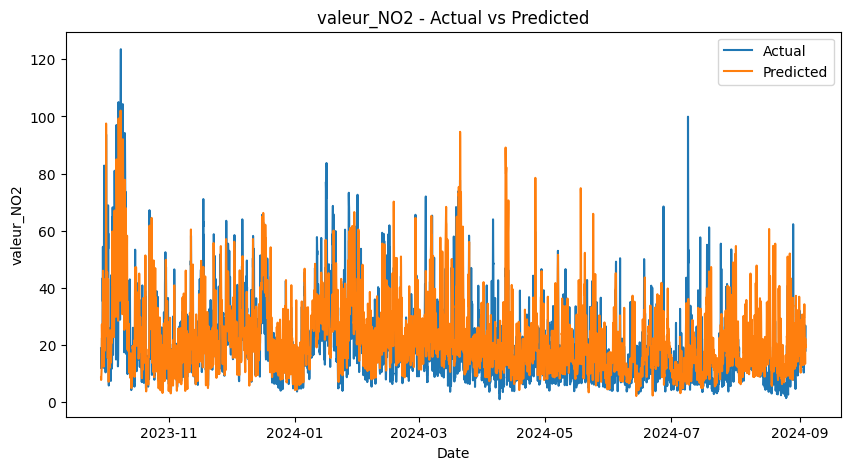

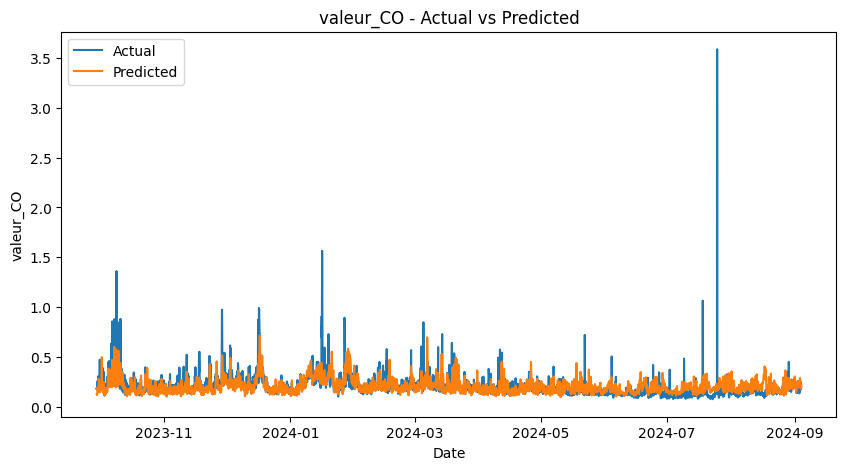

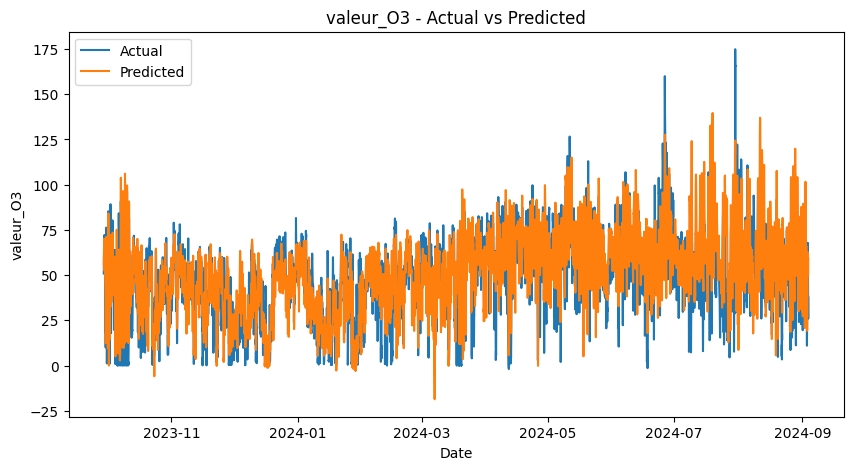

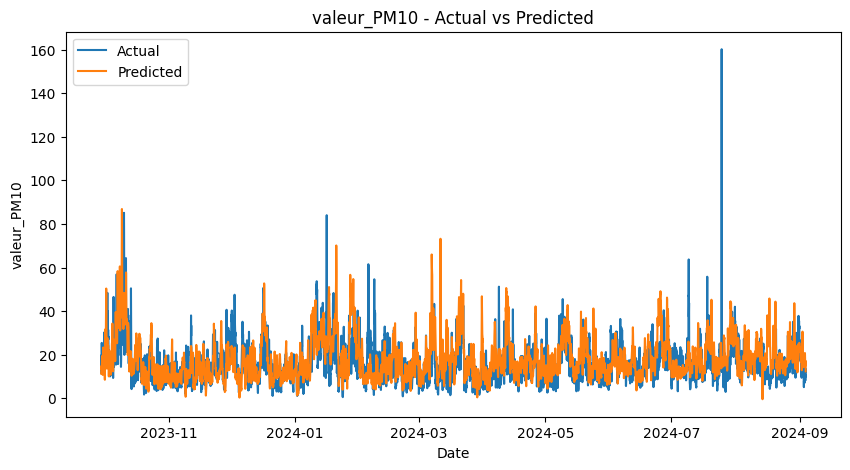

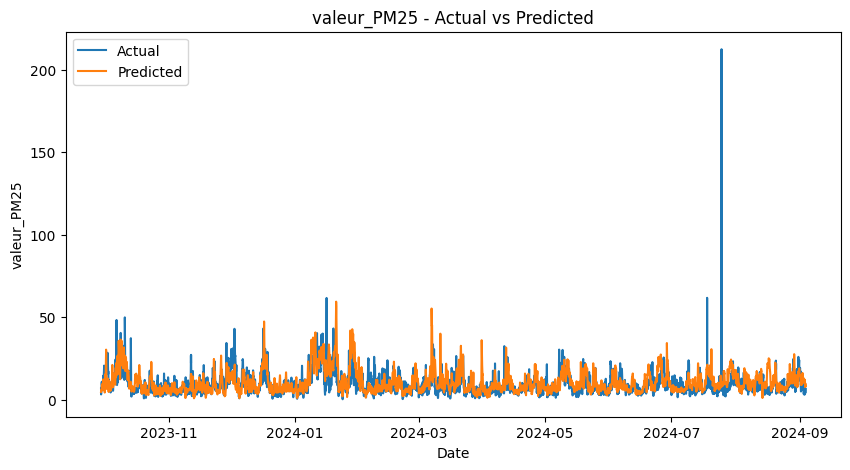

In [191]:
import matplotlib.pyplot as plt

# Extract the dates for the test dataset
test_dates = df.index[train_size + SEQ_LENGTH :]

for i, col in enumerate(target_columns):
    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, actuals[:, i], label="Actual")
    plt.plot(test_dates, predictions[:, i], label="Predicted")
    plt.title(f"{col} - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()


In [219]:
import featuretools as ft

In [220]:
df.reset_index(inplace=True)
df["date"] = pd.to_datetime(df["date"])


In [221]:
feature_df = df.drop(columns=target_columns)


In [223]:
feature_df

,date,apparent_temperature,cloud_cover,cloud_cover_high,cloud_cover_low,cloud_cover_mid,dew_point_2m,diffuse_radiation,direct_normal_irradiance,direct_radiation,...,precipitation_hours,precipitation_sum,rain_sum,shortwave_radiation_sum,snowfall_sum,sunshine_duration,temperature_2m_max,temperature_2m_min,wind_gusts_10m_max,wind_speed_10m_max
0,2020-01-01 00:00:00,0.337214,87.299995,0.0,97.0,0.0,2.360000,0.0,0.0,0.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
1,2020-01-01 01:00:00,-0.233696,85.500000,0.0,95.0,0.0,2.060000,0.0,0.0,0.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
2,2020-01-01 02:00:00,-0.615977,84.599998,0.0,94.0,0.0,1.910000,0.0,0.0,0.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
3,2020-01-01 03:00:00,-0.663568,84.599998,0.0,94.0,0.0,1.910000,0.0,0.0,0.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
4,2020-01-01 04:00:00,-0.911623,89.099998,0.0,99.0,0.0,1.910000,0.0,0.0,0.0,...,9.0,1.5,1.5,2.16,0.0,10429.040039,9.310000,5.21,36.360001,19.855558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,19.869907,38.700001,100.0,3.0,10.0,12.710000,32.0,0.0,0.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40987,2024-09-03 19:00:00,18.508705,33.300003,100.0,1.0,4.0,12.610001,3.0,0.0,0.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40988,2024-09-03 20:00:00,16.772964,42.300003,100.0,13.0,1.0,12.710000,0.0,0.0,0.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530
40989,2024-09-03 21:00:00,15.663885,40.200001,100.0,8.0,5.0,12.160000,0.0,0.0,0.0,...,4.0,1.6,1.6,15.23,0.0,39708.074219,21.710001,15.41,20.519999,11.275530


In [224]:
# Define the EntitySet
es = ft.EntitySet(id="air_quality")

# Add the feature DataFrame to the EntitySet, specifying the time index
es.add_dataframe(
    dataframe_name="measurements",
    dataframe=feature_df,
    index="index",
    time_index="date",
)

# Perform Deep Feature Synthesis with various aggregation and transformation primitives
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="measurements",
    agg_primitives=["mean", "std", "max", "min", "skew", "trend"],
    trans_primitives=["day", "month", "year", "hour"],
)


c:\Users\ameya\miniconda3\envs\air\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
c:\Users\ameya\miniconda3\envs\air\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(
c:\Users\ameya\miniconda3\envs\air\Lib\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['max', 'mean', 'min', 'skew', 'std', 'trend']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


In [225]:
feature_matrix

,apparent_temperature,cloud_cover,cloud_cover_high,cloud_cover_low,cloud_cover_mid,dew_point_2m,diffuse_radiation,direct_normal_irradiance,direct_radiation,et0_fao_evapotranspiration,...,snowfall_sum,sunshine_duration,temperature_2m_max,temperature_2m_min,wind_gusts_10m_max,wind_speed_10m_max,DAY(date),HOUR(date),MONTH(date),YEAR(date)
index,,,,,,,,,,,,,,,,,,,,,
0,0.337214,87.299995,0.0,97.0,0.0,2.360000,0.0,0.0,0.0,0.000000,...,0.0,10429.040039,9.310000,5.21,36.360001,19.855558,1,0,1,2020
1,-0.233696,85.500000,0.0,95.0,0.0,2.060000,0.0,0.0,0.0,0.000000,...,0.0,10429.040039,9.310000,5.21,36.360001,19.855558,1,1,1,2020
2,-0.615977,84.599998,0.0,94.0,0.0,1.910000,0.0,0.0,0.0,0.000000,...,0.0,10429.040039,9.310000,5.21,36.360001,19.855558,1,2,1,2020
3,-0.663568,84.599998,0.0,94.0,0.0,1.910000,0.0,0.0,0.0,0.000000,...,0.0,10429.040039,9.310000,5.21,36.360001,19.855558,1,3,1,2020
4,-0.911623,89.099998,0.0,99.0,0.0,1.910000,0.0,0.0,0.0,0.000000,...,0.0,10429.040039,9.310000,5.21,36.360001,19.855558,1,4,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,19.869907,38.700001,100.0,3.0,10.0,12.710000,32.0,0.0,0.0,0.055550,...,0.0,39708.074219,21.710001,15.41,20.519999,11.275530,3,18,9,2024
40987,18.508705,33.300003,100.0,1.0,4.0,12.610001,3.0,0.0,0.0,0.050300,...,0.0,39708.074219,21.710001,15.41,20.519999,11.275530,3,19,9,2024
40988,16.772964,42.300003,100.0,13.0,1.0,12.710000,0.0,0.0,0.0,0.008149,...,0.0,39708.074219,21.710001,15.41,20.519999,11.275530,3,20,9,2024


In [226]:
# Merge synthesized features with the original target columns
final_data = feature_matrix.merge(
    df[target_columns + ["date"]], left_index=True, right_index=True
)
final_data.set_index("date", inplace=True)


In [227]:
import pickle

# Save feature definitions (feature_defs) to a file
with open("feature_defs.pkl", "wb") as f:
    pickle.dump(feature_defs, f)


In [228]:
# Scale features and targets separately to avoid data leakage
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

final_data[feature_matrix.columns] = scaler_features.fit_transform(
    final_data[feature_matrix.columns]
)
final_data[target_columns] = scaler_targets.fit_transform(final_data[target_columns])


In [229]:
# Create train and test datasets
train_size = int(0.8 * len(final_data))
train_dataset = TimeSeriesDataset(
    final_data.iloc[:train_size],
    feature_matrix.columns,
    target_columns,
    seq_length=SEQ_LENGTH,
)
test_dataset = TimeSeriesDataset(
    final_data.iloc[train_size:],
    feature_matrix.columns,
    target_columns,
    seq_length=SEQ_LENGTH,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [230]:
# Initialize the model, loss function, and optimizer
input_size = len(feature_matrix.columns)
hidden_size = 64
target_size = len(target_columns)

model = MultiTargetLSTM(
    input_size=input_size, hidden_size=hidden_size, target_size=target_size
).to("cuda")
criterion = criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [231]:
# Training loop

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}")


Epoch [1/50], Train Loss: 0.0335
Epoch [2/50], Train Loss: 0.0259
Epoch [3/50], Train Loss: 0.0249
Epoch [4/50], Train Loss: 0.0242
Epoch [5/50], Train Loss: 0.0235
Epoch [6/50], Train Loss: 0.0230
Epoch [7/50], Train Loss: 0.0224
Epoch [8/50], Train Loss: 0.0221
Epoch [9/50], Train Loss: 0.0216
Epoch [10/50], Train Loss: 0.0212
Epoch [11/50], Train Loss: 0.0209
Epoch [12/50], Train Loss: 0.0204
Epoch [13/50], Train Loss: 0.0200
Epoch [14/50], Train Loss: 0.0196
Epoch [15/50], Train Loss: 0.0193
Epoch [16/50], Train Loss: 0.0190
Epoch [17/50], Train Loss: 0.0187
Epoch [18/50], Train Loss: 0.0184
Epoch [19/50], Train Loss: 0.0181
Epoch [20/50], Train Loss: 0.0178
Epoch [21/50], Train Loss: 0.0175
Epoch [22/50], Train Loss: 0.0173
Epoch [23/50], Train Loss: 0.0169
Epoch [24/50], Train Loss: 0.0166
Epoch [25/50], Train Loss: 0.0164
Epoch [26/50], Train Loss: 0.0162
Epoch [27/50], Train Loss: 0.0159
Epoch [28/50], Train Loss: 0.0157
Epoch [29/50], Train Loss: 0.0155
Epoch [30/50], Train Lo

In [232]:
# Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * x_batch.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0325


In [233]:
# Example of making predictions (e.g., on test data)
with torch.no_grad():
    predictions = []
    actuals = []
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to("cuda")
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

# Reverse the scaling for better interpretability if needed
predictions = scaler_targets.inverse_transform(predictions)
actuals = scaler_targets.inverse_transform(actuals)

In [234]:
# Calculate mean absolute error
mae = np.mean(np.abs(predictions - actuals), axis=0)
print("Mean Absolute Error (MAE):")
print(pd.Series(mae, name="MAE", index=target_columns))


Mean Absolute Error (MAE):
valeur_NO2      8.307352
valeur_CO       0.055123
valeur_O3      14.771715
valeur_PM10     6.441946
valeur_PM25     4.494781
Name: MAE, dtype: float32


In [235]:
# Calculate R-squared
ss_res = np.sum((actuals - predictions) ** 2, axis=0)
ss_tot = np.sum((actuals - np.mean(actuals, axis=0)) ** 2, axis=0)
r2 = 1 - ss_res / ss_tot
print("R-squared:")
print(pd.Series(r2, name="R2", index=target_columns))


R-squared:
valeur_NO2     0.233788
valeur_CO      0.229848
valeur_O3      0.296420
valeur_PM10   -0.104432
valeur_PM25   -0.048976
Name: R2, dtype: float32


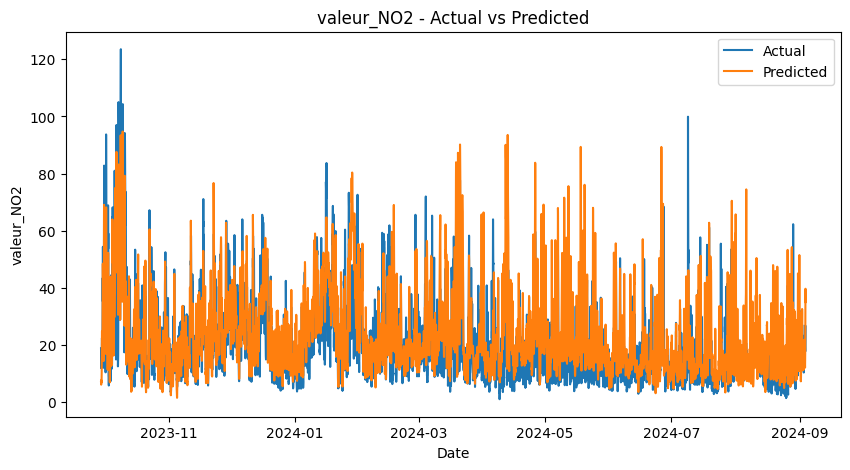

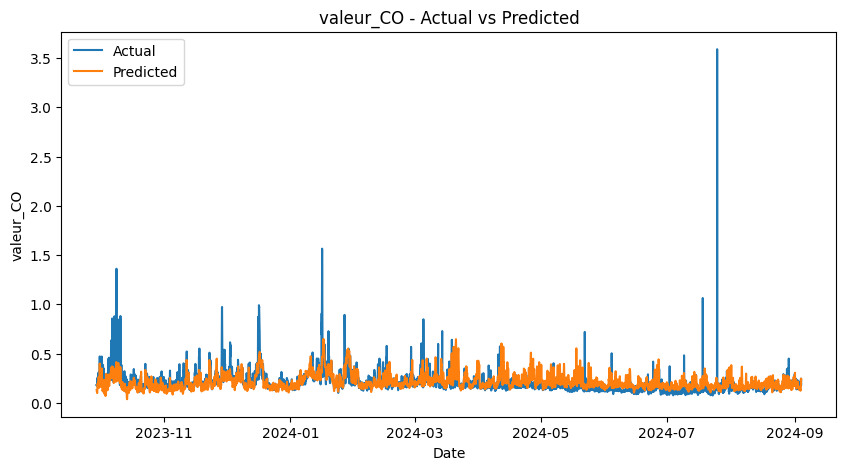

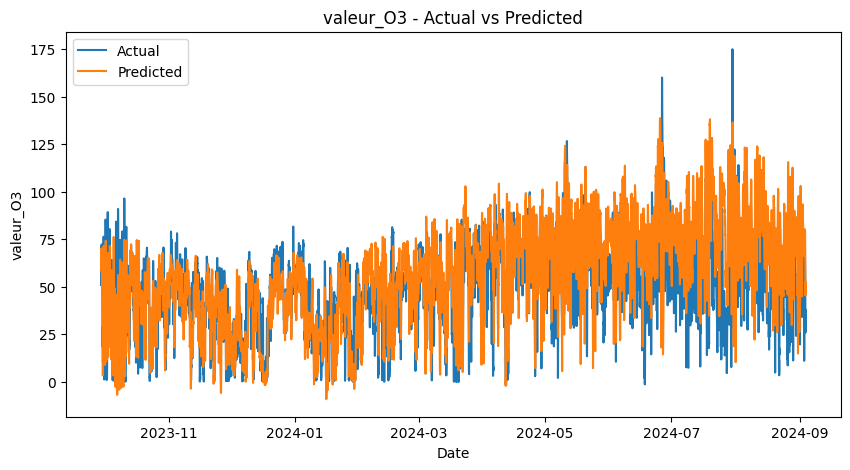

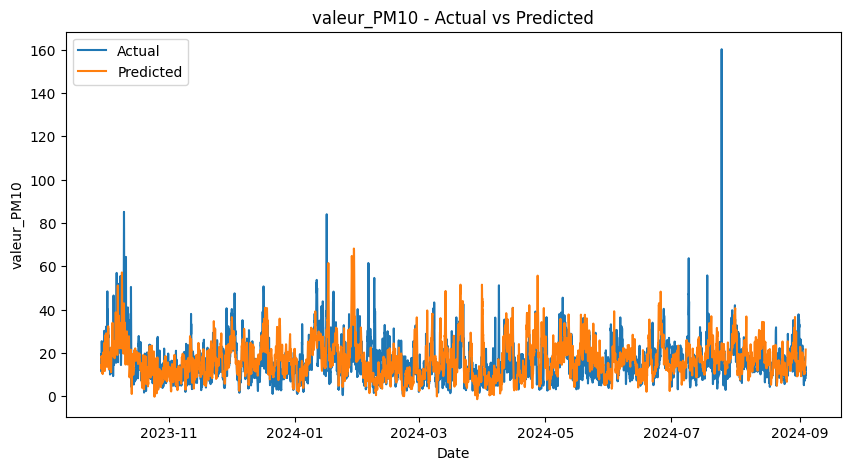

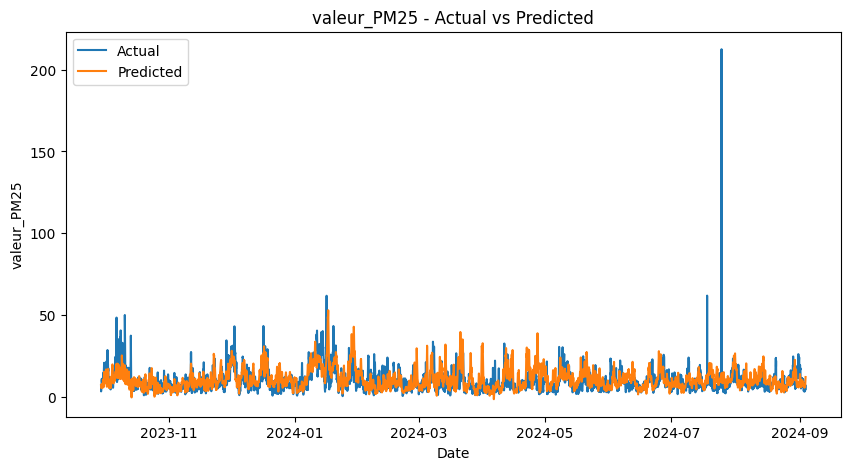

In [236]:
# Extract the dates for the test dataset
test_dates = df["date"].iloc[train_size + SEQ_LENGTH :]

for i, col in enumerate(target_columns):
    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, actuals[:, i], label="Actual")
    plt.plot(test_dates, predictions[:, i], label="Predicted")
    plt.title(f"{col} - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [142]:
df_unknown = pd.read_csv("../data/test_weather_merged_24H.csv")

In [143]:
df_unknown.rename(columns={"Unnamed: 0": "date"}, inplace=True)

df_unknown.set_index("date", inplace=True)

In [144]:
df_unknown.index = pd.to_datetime(df_unknown.index)

df_unknown.rename_axis("id", inplace=True)

In [147]:
# Ensure df_unknown only has feature columns
df_unknown[feature_columns] = scaler_features.transform(df_unknown[feature_columns])

padding_data = df.iloc[-SEQ_LENGTH:][feature_columns]  # Last 24 hours of known data

df_unknown_padded = pd.concat([padding_data, df_unknown])
# Predict on unknown data
unknown_dataset = TimeSeriesDataset(
    df_unknown_padded, feature_columns, target_columns=None, seq_length=SEQ_LENGTH
)
unknown_loader = DataLoader(unknown_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    predictions = []
    for x_batch in unknown_loader:  # Only x_batch because targets are missing
        x_batch = x_batch.to("cuda")
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)

# Remove the padding predictions (first 24 hours)
predictions = predictions[SEQ_LENGTH:]

# Reverse the scaling on predictions
predictions = scaler_targets.inverse_transform(predictions)


In [148]:
df_predictions = pd.DataFrame(
    predictions, columns=target_columns, index=df_unknown.index[SEQ_LENGTH:]
)

In [149]:
df_predictions.reset_index(inplace=True)

In [150]:
df_predictions["id"] = df_predictions["id"].dt.strftime("%Y-%m-%d %H")


In [151]:
df_predictions.to_csv("../submissions/predictions_3.csv", index=False)

In [152]:
df_predictions

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2024-09-03 23,18.793446,0.227970,65.474197,16.477028,11.314978
1,2024-09-04 00,17.750786,0.223064,66.490204,16.454521,11.221722
2,2024-09-04 01,17.760393,0.215569,56.308567,17.761600,11.969998
3,2024-09-04 02,15.491031,0.200493,51.618958,17.845207,12.516083
4,2024-09-04 03,16.647810,0.196713,48.574108,18.763102,12.765230
...,...,...,...,...,...,...
499,2024-09-24 18,31.747185,0.285995,17.078867,16.596636,10.187816
500,2024-09-24 19,34.872414,0.315358,13.371674,18.078882,11.675865
501,2024-09-24 20,36.389774,0.334055,11.845118,18.892670,12.696960
502,2024-09-24 21,30.991804,0.327782,16.778940,17.340883,12.272358
